In [1]:
!pip install biopandas &> /dev/null
!pip install biopython &> /dev/null

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/kaggle/input/sabdab-proteins/')
from SequenceUtilities import seqID, getNumbering

In [3]:
# Download dataset and filtere it to a homo sapiens
import json
def loadSoft(_x):
    try:
        return json.loads(_x)
    except:
        return _x
df = pd.read_csv('/kaggle/input/sabdab-proteins/sabdab_summary.csv')
df = df[df['antigen_species'] == 'homo sapiens']
df['vh_numbered'] = df['vh_numbered'].apply(loadSoft)
df['vl_numbered'] = df['vl_numbered'].apply(loadSoft)

df_TC = df
df_TC = df_TC.drop(['affinity', 'affinity_method'], axis=1)

df_affinity = pd.read_csv('/kaggle/input/sabdab-proteins/20220918_0660132_summary.tsv', sep='\t')
df_affinity = df_affinity[df_affinity['antigen_species'] == 'homo sapiens']
df_affinity.rename(columns={"pdb": "pdb_id"}, inplace=True)
df_affinity_clean = pd.DataFrame()
df_affinity_clean['pdb_id'] = df_affinity['pdb_id'].apply(loadSoft)
df_affinity_clean['affinity'] = df_affinity['affinity'].apply(loadSoft)
df_affinity_clean['affinity_method'] = df_affinity['affinity_method'].apply(loadSoft)
df_affinity_clean = df_affinity_clean.drop_duplicates()

df_merged = pd.merge(df_affinity_clean, df_TC, how='inner', on=['pdb_id'])
df_merged = df_merged.drop_duplicates(subset=['pdb_id'], keep=False) 
del df, df_TC, df_affinity, df_affinity_clean
df = df_merged

# filtered dataset by homologous ABS
def remove_homologous_Abs(df):
    duplicate_to_del = []
    for i, row_i in df.iterrows():
        if row_i['l3_length'] <= 0:
            continue
        max_h = 0
        for j, row_j in df.iterrows():
            if i == j:
                continue
            hid = seqID(row_i['vh_numbered'], row_j['vh_numbered'], getNumbering('H'))
            if hid > max_h:
                max_h = hid
                max_j = row_j
        if max_h > 0.95:
            aff_i = -np.log10(row_i['affinity'])
            aff_j = -np.log10(max_j['affinity'])
            if (row_i['pdb_id'] not in duplicate_to_del) and (max_j['pdb_id'] not in duplicate_to_del):
                if abs(aff_i - 9) > abs(aff_j - 9):
                    duplicate_to_del.append(max_j['pdb_id'])
                else:
                    duplicate_to_del.append(row_i['pdb_id'])
    return duplicate_to_del

all_duplicates = []
i = 1
while True:
    duplicate_to_del = remove_homologous_Abs(df)
    if not duplicate_to_del:
        break
    print(duplicate_to_del)
    print(f'Removing high homology antibodies: round {i}')
    all_duplicates.append(duplicate_to_del)
    df = df[~df['pdb_id'].isin(duplicate_to_del)]
    i += 1

duplicate_to_del = sum(all_duplicates, [])
df = df_merged

['5nh3', '6d6t', '4g6j', '1op9', '3be1', '6ejg', '4zff', '2wub', '3p0y', '4zfg', '5yhl', '4ps4', '5sx5', '4kv5', '5d72', '3b2u', '5y80', '3eoa', '5tru']
Removing high homology antibodies: round 1
['3b2v', '3l5x', '4kxz']
Removing high homology antibodies: round 2


In [4]:
df_merged.head(5)

,pdb_id,affinity,affinity_method,antigen_chain_1,antigen_chain_2,antigen_chain_3,antigen_het_name,antigen_name,antigen_sequence_1,antigen_sequence_2,...,l3_length,l3_chothia,l1_north,l1_north_seq,l2_north,l2_north_seq,l3_north,l3_north_seq,missing_antigen_chains,has_antigen
0,5wux,2.740000e-11,SPR,G,NaN,NaN,NaN,tumor necrosis factor alpha,SDKPVAHVVANPQAEGQLQWLNRRANALLANGVELRDNQLVVPSEG...,NaN,...,9.0,1/9A,L1-11-A,KASQNVGTNVA,L2-8-A,YSASFLYS,"L3-9,10-A",QQYNIYPLT,NaN,True
1,4k9e,6.400000e-12,SPR,C,NaN,NaN,NaN,mast/stem cell growth factor receptor kit,GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFT...,NaN,...,10.0,?/10A,None,RASQRGLRNVAVA,L2-8-A,YSASSLYS,"L3-9,10-A",QQWAVHSLIT,NaN,True
2,1jps,1.000000e-10,SPR,T,NaN,NaN,NaN,tissue factor,NTVAAYNLTWKSTNFKTILEWEPKPVNQVYTVQISTKSGDWKSKCF...,NaN,...,9.0,1/9A,L1-11-A,RASRDIKSYLN,L2-8-A,YYATSLAE,"L3-9,10-A",LQHGESPWT,NaN,True
3,1iqd,1.400000e-11,SPR,C,NaN,NaN,NaN,human factor viii,CSMPLGMESKAISDAQITASSYFTNMFATWSPSKARLHLQGRSNAW...,NaN,...,9.0,1/9A,L1-12-A,RASQSFSSSYLA,L2-8-A,YGASTRAT,L3-9-A,QKYGTSAIT,NaN,True
4,5nh3,9.730000e-10,Unknown,B,NaN,NaN,NaN,activin receptor type-2a,SETQECLFFNANWEKDRTNQTGVEPCYGDKDKRRHCFATWKNISGS...,NaN,...,11.0,5/11A,L1-14-A,TGTSSDVGSYNYVN,L2-8-A,YGVSKRPS,"L3-10,11-A",GTFAGGSYYGV,NaN,True


<AxesSubplot: title={'center': 'resolution'}, ylabel='Frequency'>

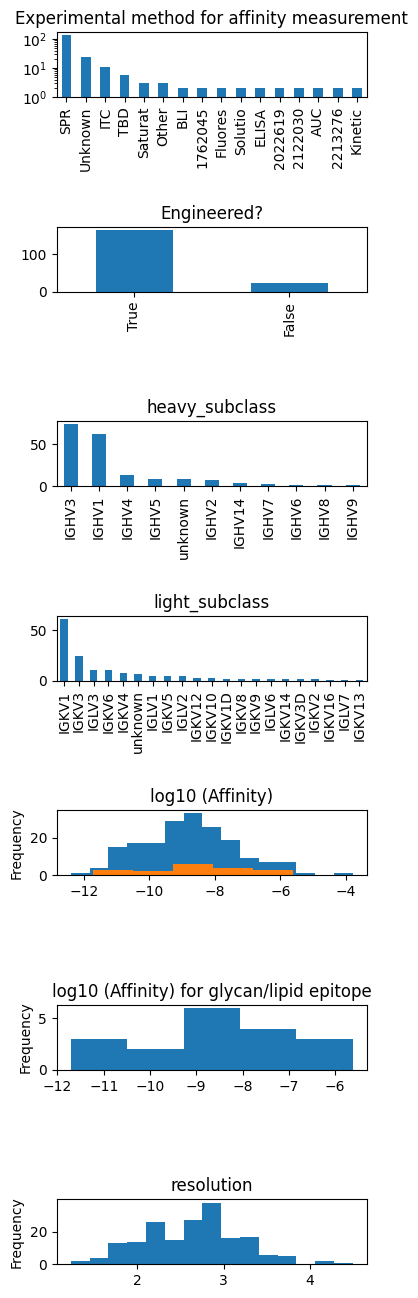

In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


non_PPI = ['4k9e','4aei','5hys','5te4','4jzj','5c6t','3ngb','2aeq','1nma','4hlz','3g6d','1qfw','1fe8','4jkp','2ny7','6bck','6mft','5u7m','4r2g','4f9l','6a67','3rvw','4fqj','5czx','5cd5','5igx','5kvd','6bkc','4dtg','3idy','5vob','3ubx','4hwb','4dkf','3q1s','3sdy','4f37','3lev','4gms','5u8q','5lcv','5xwd','5anm','6a0z','6bf4','5j3h','4j4p']
df_merged_nonPPI = df_merged[df_merged['pdb_id'].isin(non_PPI)]

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(4, 16), dpi=100, sharex=False, sharey=False)
plt.subplots_adjust(hspace=2)
ax1 = plt.subplot(711)
ax1.set_title('Experimental method for affinity measurement')
df_merged['affinity_method'].apply(lambda x: str(x)[:7]).value_counts().plot(kind='bar', ax=ax1, log=True)

ax2 = plt.subplot(712)
ax2.set_title('Engineered?')
df_merged['engineered'].value_counts().plot(kind='bar', ax=ax2)

ax3 = plt.subplot(713)
ax3.set_title('heavy_subclass')
df_merged['heavy_subclass'].value_counts().plot(kind='bar', ax=ax3)

ax4 = plt.subplot(714)
ax4.set_title('light_subclass')
df_merged['light_subclass'].value_counts().plot(kind='bar', ax=ax4)

ax5 = plt.subplot(715)
ax5.set_title('log10 (Affinity)')
np.log10(df_merged['affinity']).plot(kind='hist', bins=15, ax=ax5)
np.log10(df_merged_nonPPI['affinity']).plot(kind='hist', bins=5, ax=ax5)

ax6 = plt.subplot(716)
ax6.set_title('log10 (Affinity) for glycan/lipid epitope')
np.log10(df_merged_nonPPI['affinity']).plot(kind='hist', bins=5, ax=ax6)

ax7 = plt.subplot(717)
ax7.set_title('resolution')
df_merged['resolution'].plot(kind='hist', bins=15, ax=ax7)

In [26]:

RECALCULATE_SASA_CLASSES = False #True, if you want recalculate classes
RECALCULATE_AA_SC = False #True, if you want recalculate AA

!mkdir -p /kaggle/working/protein_interactions/chothia_opt_relaxed/
import torch

if RECALCULATE_SASA_CLASSES:
    from biopandas.pdb import PandasPdb
    !pip install freesasa
    import freesasa
    def getAntigenChains(_row):
        toret = []
        for i in range(1,4):
            if type(_row['antigen_chain_{}'.format(i)]) is str:
                toret+=[_row['antigen_chain_{}'.format(i)]]
        return ','.join(toret)

    def getParatopeChains(_row):
        toret = ['H']
        if type(_row['lchain']) is str:
            toret+=['L']
        return ','.join(toret)


    def separateComplex(pdb_path,ab_chains,antigen_chains):
        if not(ab_chains=='H,L' or ab_chains=='L,H'):
            raise
        antigen_chains = antigen_chains.split(',')
        ppdb = PandasPdb().read_pdb(pdb_path)
        atom_df = ppdb.df['ATOM'].copy(deep=True)
        hetatm_df = ppdb.df['HETATM'].copy(deep=True)
        ppdb_ab = PandasPdb()
        ppdb_ab.df['ATOM'] = atom_df[atom_df.chain_id.isin(['H','L'])].reset_index().drop('index',axis=1)
        ppdb_ab.df['HETATM'] = pd.DataFrame(columns=hetatm_df.columns)
        ppdb_ag = PandasPdb()
        ppdb_ag.df['ATOM'] = atom_df[atom_df.chain_id.isin(antigen_chains)].reset_index().drop('index',axis=1)
        ppdb_ag.df['HETATM'] = pd.DataFrame(columns=hetatm_df.columns)
        ppdb_ab.to_pdb(records=['ATOM','HETATM'],
                       gz=False,
                       append_newline=True,
                       path='/kaggle/working/protein_interactions'+pdb_path.split('/sabdab-proteins/chothia_opt_relaxed')[1]+'_ab.pdb')
        ppdb_ag.to_pdb(records=['ATOM','HETATM'], 
                       gz=False, 
                       append_newline=True,
                       path='/kaggle/working/protein_interactions'+pdb_path.split('/sabdab-proteins/chothia_opt_relaxed')[1]+'_ag.pdb')

    def classifyPoint(rasam,rasac,drasa_thresh=.1):
        #**Interior**:	rASAc<.25	drASA=0 0 
        #**Surface**:	  rASAc>.25	drASA=0 1
        #**Support**:	  rASAm<.25	drASA=0 2
        #**Rim**:		rASAc>.25	drASA>0 3
        #**Core**:	rASAm>.25	rASAc<.25	drASA>0 4
        toret = -1
        drasa = rasam-rasac
        if drasa<drasa_thresh:
            if rasac<.25:
                toret = 0
            elif rasac>=.25:
                toret = 1
        else:
            if rasam<.25:
                toret = 2
            elif rasac>.25:
                toret=3
            else: #rasam>=.25, rasac<=.25
                toret = 4

        return toret


    def getInterfaceClasses(pdb_path,antibody_chains,antigen_chains):
        separateComplex(pdb_path,antibody_chains,antigen_chains)
        comp = freesasa.Structure(pdb_path)
        comp = freesasa.calc(comp)
        ab   = freesasa.Structure('/kaggle/working/protein_interactions'+pdb_path.split('/sabdab-proteins/chothia_opt_relaxed')[1]+'_ab.pdb')
        ab   = freesasa.calc(ab)
        ag   = freesasa.Structure('/kaggle/working/protein_interactions'+pdb_path.split('/sabdab-proteins/chothia_opt_relaxed')[1]+'_ag.pdb')
        ag   = freesasa.calc(ag)
        sasa_class = {}
        for c in ab.residueAreas():
            sasa_class[c] = {}
            for r in ab.residueAreas()[c]:
                rasam = ab.residueAreas()[c][r].relativeTotal
                rasac = comp.residueAreas()[c][r].relativeTotal
                sasa_class[c][r] = classifyPoint(rasam,rasac)
            sasa_class[c] = {}
            for r in ag.residueAreas()[c]:
                rasam = ag.residueAreas()[c][r].relativeTotal
                rasac = comp.residueAreas()[c][r].relativeTotal
                sasa_class[c][r] = classifyPoint(rasam,rasac)
        return sasa_class

    import time
    sasa_classes = {}
    t = time.time()
    fails = []
    for i in df.index:
        try:
            pdb_path = '/kaggle/input/sabdab-proteins/chothia_opt_relaxed/chothia_opt_relaxed/{}_clean_opt_0.pdb'.format(df.loc[i,'pdb_id'])
            antibody_chains = getParatopeChains(df.loc[i])
            antigen_chains = getAntigenChains(df.loc[i])
            sasa_classes[df.loc[i,'pdb_id']] = getInterfaceClasses(pdb_path,antibody_chains,antigen_chains)
        except:
            print('FAILED: {}'.format(i))
            fails+=[i]

    torch.save(sasa_classes, '/kaggle/working/protein_interactions/residue_interface_classes.pt')
else:
    sasa_classes = torch.load('/kaggle/input/sabdab-proteins/residue_interface_classes.pt')


# BB Distances Matrix
import torch
import warnings
from Bio import BiopythonWarning
from Bio.PDB import Selection
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.Polypeptide import three_to_one, three_to_index, is_aa

NON_STANDARD_SUBSTITUTIONS = {
    '2AS':'ASP', '3AH':'HIS', '5HP':'GLU', 'ACL':'ARG', 'AGM':'ARG', 'AIB':'ALA', 'ALM':'ALA', 'ALO':'THR', 'ALY':'LYS', 'ARM':'ARG',
    'ASA':'ASP', 'ASB':'ASP', 'ASK':'ASP', 'ASL':'ASP', 'ASQ':'ASP', 'AYA':'ALA', 'BCS':'CYS', 'BHD':'ASP', 'BMT':'THR', 'BNN':'ALA',
    'BUC':'CYS', 'BUG':'LEU', 'C5C':'CYS', 'C6C':'CYS', 'CAS':'CYS', 'CCS':'CYS', 'CEA':'CYS', 'CGU':'GLU', 'CHG':'ALA', 'CLE':'LEU', 'CME':'CYS',
    'CSD':'ALA', 'CSO':'CYS', 'CSP':'CYS', 'CSS':'CYS', 'CSW':'CYS', 'CSX':'CYS', 'CXM':'MET', 'CY1':'CYS', 'CY3':'CYS', 'CYG':'CYS',
    'CYM':'CYS', 'CYQ':'CYS', 'DAH':'PHE', 'DAL':'ALA', 'DAR':'ARG', 'DAS':'ASP', 'DCY':'CYS', 'DGL':'GLU', 'DGN':'GLN', 'DHA':'ALA',
    'DHI':'HIS', 'DIL':'ILE', 'DIV':'VAL', 'DLE':'LEU', 'DLY':'LYS', 'DNP':'ALA', 'DPN':'PHE', 'DPR':'PRO', 'DSN':'SER', 'DSP':'ASP',
    'DTH':'THR', 'DTR':'TRP', 'DTY':'TYR', 'DVA':'VAL', 'EFC':'CYS', 'FLA':'ALA', 'FME':'MET', 'GGL':'GLU', 'GL3':'GLY', 'GLZ':'GLY',
    'GMA':'GLU', 'GSC':'GLY', 'HAC':'ALA', 'HAR':'ARG', 'HIC':'HIS', 'HIP':'HIS', 'HMR':'ARG', 'HPQ':'PHE', 'HTR':'TRP', 'HYP':'PRO',
    'IAS':'ASP', 'IIL':'ILE', 'IYR':'TYR', 'KCX':'LYS', 'LLP':'LYS', 'LLY':'LYS', 'LTR':'TRP', 'LYM':'LYS', 'LYZ':'LYS', 'MAA':'ALA', 'MEN':'ASN',
    'MHS':'HIS', 'MIS':'SER', 'MLE':'LEU', 'MPQ':'GLY', 'MSA':'GLY', 'MSE':'MET', 'MVA':'VAL', 'NEM':'HIS', 'NEP':'HIS', 'NLE':'LEU',
    'NLN':'LEU', 'NLP':'LEU', 'NMC':'GLY', 'OAS':'SER', 'OCS':'CYS', 'OMT':'MET', 'PAQ':'TYR', 'PCA':'GLU', 'PEC':'CYS', 'PHI':'PHE',
    'PHL':'PHE', 'PR3':'CYS', 'PRR':'ALA', 'PTR':'TYR', 'PYX':'CYS', 'SAC':'SER', 'SAR':'GLY', 'SCH':'CYS', 'SCS':'CYS', 'SCY':'CYS',
    'SEL':'SER', 'SEP':'SER', 'SET':'SER', 'SHC':'CYS', 'SHR':'LYS', 'SMC':'CYS', 'SOC':'CYS', 'STY':'TYR', 'SVA':'SER', 'TIH':'ALA',
    'TPL':'TRP', 'TPO':'THR', 'TPQ':'ALA', 'TRG':'LYS', 'TRO':'TRP', 'TYB':'TYR', 'TYI':'TYR', 'TYQ':'TYR', 'TYS':'TYR', 'TYY':'TYR'
}


RESIDUE_SIDECHAIN_POSTFIXES = {
    'A': ['CB'],
    'R': ['CB', 'CG', 'CD', 'NE', 'CZ', 'NH1', 'NH2'],
    'N': ['CB', 'CG', 'OD1', 'ND2'],
    'D': ['CB', 'CG', 'OD1', 'OD2'],
    'C': ['CB', 'SG'],
    'E': ['CB', 'CG', 'CD', 'OE1', 'OE2'],
    'Q': ['CB', 'CG', 'CD', 'OE1', 'NE2'],
    'G': [],
    'H': ['CB', 'CG', 'ND1', 'CD2', 'CE1', 'NE2'],
    'I': ['CB', 'CG1', 'CG2', 'CD1'],
    'L': ['CB', 'CG', 'CD1', 'CD2'],
    'K': ['CB', 'CG', 'CD', 'CE', 'NZ'],
    'M': ['CB', 'CG', 'SD', 'CE'],
    'F': ['CB', 'CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
    'P': ['CB', 'CG', 'CD'],
    'S': ['CB', 'OG'],
    'T': ['CB', 'OG1', 'CG2'],
    'W': ['CB', 'CG', 'CD1', 'CD2', 'NE1', 'CE2', 'CE3', 'CZ2', 'CZ3', 'CH2'],
    'Y': ['CB', 'CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ', 'OH'],    
    'V': ['CB', 'CG1', 'CG2'],
}

GLY_INDEX = 5
ATOM_N, ATOM_CA, ATOM_C, ATOM_O, ATOM_CB  = 0, 1, 2, 3, 4

CDRS = {'H1':(25,33),#(23,36),
        'H2':(50,58),#(50,58),
        'H3':(92,104),#(93,102),
        'L1':(25,33),#(24,34),
        'L2':(49,53),#(49,56),
        'L3':(90,97)}#(89,97)}

def i2res(i,data):
    return data['chain_id'][i]+str(data['resseq'][i].numpy())+data['icode'][i].strip()

def augmented_three_to_one(three):
    if three in NON_STANDARD_SUBSTITUTIONS:
        three = NON_STANDARD_SUBSTITUTIONS[three]
    return three_to_one(three)


def augmented_three_to_index(three):
    if three in NON_STANDARD_SUBSTITUTIONS:
        three = NON_STANDARD_SUBSTITUTIONS[three]
    return three_to_index(three)


def augmented_is_aa(three):
    if three in NON_STANDARD_SUBSTITUTIONS:
        three = NON_STANDARD_SUBSTITUTIONS[three]
    return is_aa(three, standard=True)


def is_hetero_residue(res):
    return len(res.id[0].strip()) > 0


def get_atom_name_postfix(atom):
    name = atom.get_name()
    return name

def get_virtual_cb(pos5):
    #pos
    b = pos5[:,ATOM_CA,:] - pos5[:,ATOM_N]
    c = pos5[:,ATOM_C,:]  - pos5[:,ATOM_CA]
    a = torch.linalg.cross(b,c)
    return -0.58273431*a + 0.56802827*b - 0.54067466*c +pos5[:,ATOM_CA,:]

def get_residue_pos14(res):
    pos14 = torch.full([14, 3], float('inf'))
    suffix_to_atom = {get_atom_name_postfix(a):a for a in res.get_atoms()}
    atom_order = ['N', 'CA', 'C', 'O'] + RESIDUE_SIDECHAIN_POSTFIXES[augmented_three_to_one(res.get_resname())]
    
    d = {}
    for i, atom_suffix in enumerate(atom_order):
        if atom_suffix not in suffix_to_atom: continue
        pos14[i,0], pos14[i,1], pos14[i,2] = suffix_to_atom[atom_suffix].get_coord().tolist()
    return pos14

def numstr2tup(_n):
    import re
    match = re.match(r"([0-9]+)([a-z]+)", _n, re.I)
    if match:
        items = match.groups()
        return (int(items[0]),items[1])
    else:
        return (int(_n),' ')

def addSin(data):
    sin = pd.read_csv('/kaggle/input/sabdab-proteins/sin/sin/{}_clean_opt_sin.csv'.format(data['name']),header = None,dtype={1:str})
    sin_norm = np.nan
    with open('/kaggle/input/sabdab-proteins/sin/sin/{}_clean_opt_norm.txt'.format(data['name']),'r') as f:
        sin_norm = float(f.read())

    chain_id = sin[0].values
    resn = sin[1].values
    resi = []
    icode = []
    for r in resn:
        ri, ic = numstr2tup(r)
        resi+=[ri]
        icode+=[ic]

    resi = np.array(resi)
    icode = np.array(icode)

    if (np.all(np.array(list(data['chain_id']))==chain_id) and \
        np.all(data['resseq'].numpy()==resi) and \
        np.all(np.array(list(data['icode']))==icode))==False:
        raise

    data['sin'] = torch.Tensor(sin.loc[0:,3:].values)
    data['sin_norm'] = sin_norm
    return data


def parse_pdb(path,pdb_id,return_pos14=False,model_id=0):
    warnings.simplefilter('ignore', BiopythonWarning)
    parser = PDBParser()
    structure = parser.get_structure(None, path)
    data = parse_complex(structure,pdb_id, return_pos14, model_id)
    data = addSin(data)
    return data


def get_paratope_mask(pos14,pos14_mask,antibody_mask,antigen_mask,cutoff=4.5):
    """returns the linear indices of
       paratope residues as 
       defined by heavy atom distance <=cutoff.  
       NOTE: ASSUMES THAT ANTIBODY CHAIN(S) ARE FIRST IN THE COMPLEX"""
    
    ab = pos14[antibody_mask==True,:,:].reshape((antibody_mask==True).sum()*14,3)
    ab_mask = pos14_mask[antibody_mask==True,:,:].reshape((antibody_mask==True).sum()*14,3).all(axis=1)
    
    res_ix = torch.tensor([i for i in range((antibody_mask==True).sum()) for x in range(14)])
    res_ix = res_ix[ab_mask]
    
    ag = pos14[antigen_mask==True,:,:].reshape((antigen_mask==True).sum()*14,3)
    ag_mask = pos14_mask[antigen_mask==True,:,:].reshape((antigen_mask==True).sum()*14,3).all(axis=1)
    paratope_mask = torch.LongTensor([False]*len(antibody_mask))
    paratope_mask[res_ix[torch.cdist(ab[ab_mask,:],ag[ag_mask,:]).min(axis=1).values<=cutoff].unique()] = True
    return paratope_mask
  
def parse_complex(structure, pdb_id,return_pos14=False,model_id=None):
    if model_id is not None:
        structure = structure[model_id]
    chains = Selection.unfold_entities(structure, 'C')

    aa, resseq, icode, seq, interface_class = [], [], [], [], []
    pos14, pos14_mask = [], []
    chain_id, chain_seq = [], []
    for i, chain in enumerate(chains):
        seq_this = 0
        for res in chain:
            resname = res.get_resname()
            if not augmented_is_aa(resname): continue
            if not (res.has_id('CA') and res.has_id('C') and res.has_id('N')): continue

            # Chain
            chain_id.append(chain.get_id())
            chain_seq.append(i+1)

            # Residue types
            restype = augmented_three_to_index(resname)
            aa.append(restype)

            # Atom coordinates
            #
            pos14_this = get_residue_pos14(res)
            pos14_mask_this = pos14_this.isfinite()
            pos14.append(pos14_this.nan_to_num(posinf=99999))
            pos14_mask.append(pos14_mask_this)
            
            # Sequential number
            resseq_this = int(res.get_id()[1])
            icode_this = res.get_id()[2]    

            #sasa
            interface_class+=[sasa_classes[pdb_id][chain.get_id()][str(resseq_this)+icode_this.strip()]]


            if seq_this == 0:
                seq_this = 1
            else:
                d_resseq = resseq_this - resseq[-1]
                if d_resseq == 0: seq_this += 1
                else: seq_this += d_resseq
            resseq.append(resseq_this)
            icode.append(icode_this)
            seq.append(seq_this)
    
    
    
    if len(aa) == 0:
        return None
    
    pos14 = torch.stack(pos14)
    pos14_mask = torch.stack(pos14_mask)
    
    antibody_mask = torch.LongTensor([x in ['H','L'] for x in list(chain_id)])
    
    if not antibody_mask[0]:
        raise ValueError('ANTIBODY CHAIN(S) NOT FIRST!')
        
    antigen_mask = torch.LongTensor([x not in ['H','L'] for x in list(chain_id)])
    paratope_mask = get_paratope_mask(pos14,pos14_mask,antibody_mask,antigen_mask,cutoff=4.5)
    
    ###GET POS5
    pos5 = torch.zeros((len(pos14),5,3))
    pos5.copy_(pos14[:,[ATOM_N,ATOM_CA,ATOM_C,ATOM_O,ATOM_CB],:])
    pos5[:,ATOM_CB,:] = get_virtual_cb(pos5)
    
    pos5_mask = pos14_mask[:,[ATOM_N,ATOM_CA,ATOM_C,ATOM_O,ATOM_CB],:]
    pos5_mask[:,ATOM_CB,:] = pos5[:,ATOM_CB,:]<99999
    residue_mask = pos5_mask.all(axis=-1).all(axis=-1).int()
    toret =  {
        'name': pdb_id,
        # Chain
        'chain_id': ''.join(chain_id),
        'chain_seq': torch.LongTensor(chain_seq),
        # Sequence
        'aa': torch.LongTensor(aa), 
        'resseq': torch.LongTensor(resseq), 
        'icode': ''.join(icode), 
        'seq': torch.LongTensor(seq),
        'antibody_mask': antibody_mask,
        'antigen_mask':  antigen_mask,
        'paratope_mask': paratope_mask,
        # Atom positions
        'pos5':pos5, 
        'pos5_mask': pos5_mask,
        'residue_mask':residue_mask,
        'interface_class':torch.LongTensor(interface_class)
    }
    chain_ids = np.array(list(toret['chain_id']))
    resseq = toret['resseq'].numpy()

    for CDR in CDRS:
        toret['{}_mask'.format(CDR)] = torch.LongTensor((chain_ids==CDR[0])&(resseq>=CDRS[CDR][0])&(resseq<=CDRS[CDR][1]))
    toret['ag_mask'] = torch.LongTensor(np.isin(chain_ids,['H','L'])==False)
    
    if return_pos14==1:
        del toret['pos5']
        del toret['pos5_mask']
        toret['pos14'] = pos14
        toret['pos14_mask'] = pos14_mask

    
    return toret



import time
t = time.time()

fails = []
for i in df.index:
    pdb_path_opt  = "/kaggle/input/sabdab-proteins/chothia_opt_relaxed/chothia_opt_relaxed/{}_clean_opt_0.pdb".format(df.loc[i,'pdb_id'])
    try:
        data = parse_pdb(pdb_path_opt,df.loc[i,'pdb_id'])
    except:
        print("FAILED: {}".format(df.index[i]))
        fails+=[i]
    D = torch.sqrt(torch.sum((torch.unsqueeze(data['pos5'],0)-torch.unsqueeze(data['pos5'],1))**2,3))
    D, _  = torch.min(D,-1)
    data['D'] = D
    torch.save(data,'/kaggle/working/protein_interactions/chothia_opt_relaxed/{}.pt'.format(df.loc[i,'pdb_id']))

torch.save(fails,'/kaggle/working/protein_interactions/chothia_opt_relaxed/fails.pt')


df = df.drop(fails).reset_index().drop('index',axis=1)
print(np.round((time.time()-t)/60,2))

import time
from Bio.PDB.Polypeptide import one_to_index

if RECALCULATE_AA_SC:
    t = time.time()
    fails = []
    aa_data = {}

    for i in df.index:
        pdb_path_opt  = "/kaggle/input/sabdab-proteins/chothia_opt_relaxed/chothia_opt_relaxed/{}_clean_opt_0.pdb".format(df.loc[i,'pdb_id'])
        try:
            data = parse_pdb(pdb_path_opt,df.loc[i,'pdb_id'],True)
            ALA_INDEX = 0 
            mask = (data['aa']!=GLY_INDEX)&data['residue_mask']&(data['aa']!=ALA_INDEX)
            D = data['pos14'][mask==1,:5].unsqueeze(1)-data['pos14'][mask==1,5:].unsqueeze(2)
            maxes = torch.sqrt(torch.sum(((data['pos14_mask'][mask==1,5:,:].unsqueeze(2))*D)**2,-1)).max(axis=1)[0].min(axis=-1)[0]
            aas = data['aa'][mask==1]
            for i in range(len(aas)):
                aa = int(aas[i].numpy())
                if aa not in aa_data:
                    aa_data[aa] = []
                aa_data[aa]+=[float(maxes[i].numpy())]
        except:
            print('Failed: {}'.format(i))
            fails+=[i]
    json.dump(aa_data,open('/kaggle/working/protein_interactions/aa_bb_sc_dists.json','w'))
    print(time.time()-t)

else:
    tmp = json.load(open('/kaggle/input/sabdab-proteins/aa_bb_sc_dists.json','r'))
    aa_data = {}
    for k,v in tmp.items():
        aa_data[int(k)] = v

aa_data[one_to_index('A')] = 0
aa_data[one_to_index('G')] = 0

aa_means = torch.zeros(len(aa_data))
for k in aa_data:
    aa_means[k] = np.mean(aa_data[k])

mkdir: cannot create directory ‘/kaggle/working/protein_interactions/chothia_opt_relaxed/’: File exists
FAILED: 21
FAILED: 43
FAILED: 114
FAILED: 142
FAILED: 182
0.8
41.636908292770386


In [3]:
RECALCULATE_FEATURE_PREPROCESSING = False
from Bio.PDB.Polypeptide import index_to_one
import pickle
import json 

if RECALCULATE_FEATURE_PREPROCESSING:
    with open('/kaggle/input/sabdab-proteins/dMaSIF_v1.pkl', 'rb') as f: #v0 was first, but out of bounds missed some. Only got 429
        hotspot_res = pickle.load(f)
    aif = json.load(open('/kaggle/input/sabdab-proteins/aif_matrix.json','r'))
    for pdb in df['pdb_id']:
        data = torch.load('/kaggle/working/protein_interactions/chothia_opt_relaxed/{}.pt'.format(pdb))
        SIN_mat = pd.read_csv('/kaggle/input/sabdab-proteins/sin/sin/{}_clean_opt_sin.csv'.format(pdb), header=None)
        AIF_mat = SIN_mat.copy(deep=True)
        for col in SIN_mat.loc[:,3:].columns:
            # get AIF for every non-zero contact in SIN matrix
            AIF_mat[col] = AIF_mat.apply(lambda x: aif[x[2]+AIF_mat.loc[col-3,2]], axis=1)[AIF_mat[col] > 0]
            AIF_mat = AIF_mat.fillna(0)

        hotspots = [] 
        SIN_vals = []
        AIF_vals_tot = []
        AIF_vals_avg = []

        antigen_indices = SIN_mat.index[ (SIN_mat[0] != 'H') & (SIN_mat[0] != 'L')].tolist()
        antigen_indices = [ind + 3 for ind in antigen_indices] # shift 3 to get cols from row indices
        antibody_indices = SIN_mat.index[ (SIN_mat[0] == 'H') | (SIN_mat[0] == 'L')].tolist()
        antibody_indices = [ind + 3 for ind in antibody_indices] # shift 3 to get cols from row indices

        for i,chain in enumerate(list(data['chain_id'])):
            resi = data['resseq'][i].item()
            hotspots.append(hotspot_res[pdb][chain][resi])
            if chain in ['H','L']: # if a paratope site
                paratope_resi_score = SIN_mat.iloc[i,antigen_indices].sum() 
                SIN_vals.append(paratope_resi_score)
                AIF_vals_tot.append( AIF_mat.iloc[i,antigen_indices].sum() )
                AIF_vals_avg.append( AIF_mat.iloc[i,antigen_indices][AIF_mat.iloc[i,antigen_indices] != 0].mean() )
            else: # if epitope site
                epitope_resi_score = SIN_mat.iloc[i,antibody_indices].sum() 
                SIN_vals.append(epitope_resi_score)
                AIF_vals_tot.append( AIF_mat.iloc[i,antibody_indices].sum() )
                AIF_vals_avg.append( AIF_mat.iloc[i,antibody_indices][AIF_mat.iloc[i,antibody_indices] != 0].mean() )

        hotspot_tensor = torch.Tensor(hotspots)
        SIN_tensor = torch.Tensor(SIN_vals)
        AIF_tensor_tot = torch.Tensor(AIF_vals_tot)
        AIF_tensor_avg = torch.nan_to_num(torch.Tensor(AIF_vals_avg))

        data['dMaSIF'] = hotspot_tensor
        data['SIN'] = SIN_tensor
        data['AIF_total'] = AIF_tensor_tot
        data['AIF_average'] = AIF_tensor_avg
        torch.save(data,'/kaggle/working/protein_interactions/chothia_opt_relaxed/{}.pt'.format(pdb))

    !zip -r '/kaggle/working/protein_interactions/data_v0.zip' '/kaggle/working/protein_interactions/chothia_opt_relaxed/'

else:
    path = "/kaggle/input/sabdab-proteins/data_v0/kaggle/working/protein_interactions/chothia_opt_relaxed/"
    import os
    files = os.listdir(path)


In [5]:
CLEAN_DATASET_RELOAD = False

def get_stats(values):
    stats = []
    stats.append(np.mean(values))
    stats.append(np.std(values))
    stats.append(np.var(values))
    stats.extend(np.quantile(values, np.linspace(0.1, 0.9, 9)))
    return stats

if CLEAN_DATASET_RELOAD:
    data = []
    import torch
    import numpy as np
    for file in files:
        filepath = f'/kaggle/input/sabdab-proteins/data_v0/kaggle/working/protein_interactions/chothia_opt_relaxed/{file}'
        tensor = torch.load(filepath)
        if 'dMaSIF' in tensor:
            name = tensor['name']
            chain_id = tensor['chain_id']
            chain_seq = tensor['chain_seq']
            aa = tensor['aa']
            resseq = tensor['resseq']
            icode = tensor['icode']
            seq = tensor['seq']
            antibody_mask = tensor['antibody_mask']
            antigen_mask = tensor['antigen_mask']
            paratope_mask = tensor['paratope_mask']
            pos5 = tensor['pos5']
            pos5_mask = tensor['pos5_mask']
            residue_mask = tensor['residue_mask']
            interface_class = tensor['interface_class']
            H1_mask = tensor['H1_mask']
            H2_mask = tensor['H2_mask']
            H3_mask = tensor['H3_mask']
            L1_mask = tensor['L1_mask']
            L2_mask = tensor['L2_mask']
            L3_mask = tensor['L3_mask']
            ag_mask = tensor['ag_mask']
            sin = tensor['sin']
            sin_norm = tensor['sin_norm']
            D = tensor['D']
            dMaSIF = tensor['dMaSIF']
            SIN = tensor['SIN']
            AIF_total = tensor['AIF_total']
            AIF_average = tensor['AIF_average']

            data.append({
                'name': name,
                'chain_id': chain_id,
                'chain_seq': chain_seq,
                'aa': aa,
                'resseq': resseq,
                'icode': icode,
                'seq': seq,
                'antibody_mask': antibody_mask,
                'antigen_mask': antigen_mask,
                'paratope_mask': paratope_mask,
                'pos5': pos5,
                'pos5_mask': pos5_mask,
                'residue_mask': residue_mask,
                'interface_class': interface_class,
                'H1_mask': H1_mask,
                'H2_mask': H2_mask,
                'H3_mask': H3_mask,
                'L1_mask': L1_mask,
                'L2_mask': L2_mask,
                'L3_mask': L3_mask,
                'ag_mask': ag_mask,
                'sin': sin,
                'sin_norm': sin_norm,
                'D': D,
                'dMaSIF': dMaSIF.numpy(),
                'SIN': SIN.numpy(),
                'AIF_total': AIF_total.numpy(),
                'AIF_average': AIF_average.numpy()
            })
        else:
            continue
    filtered_data = []
    for entry in data:
        masks = [entry['H1_mask'], entry['H2_mask'], entry['H3_mask'], entry['L1_mask'], entry['L2_mask'], entry['L3_mask']]
        merged_mask = np.zeros_like(masks[0])
        for mask in masks:
            merged_mask |= mask.cpu().numpy()
        merged_mask = merged_mask.astype(np.int)
        entry['merged_mask'] = merged_mask
        
        filtered_entry = {'name': entry['name']}
        filtered_entry['interface_class'] = np.where(entry['merged_mask'] == 1, entry['interface_class'], np.nan)
        filtered_entry['interface_class'] = filtered_entry['interface_class'][~np.isnan(filtered_entry['interface_class'])]

        filtered_entry['D'] = np.where(entry['merged_mask'] == 1, entry['D'], np.nan)
        filtered_entry['D'] = filtered_entry['D'][~np.isnan(filtered_entry['D'])]

        filtered_entry['sin_norm'] = np.where(entry['merged_mask'] == 1, entry['sin_norm'], np.nan)
        filtered_entry['sin_norm'] = filtered_entry['sin_norm'][~np.isnan(filtered_entry['sin_norm'])]

        filtered_entry['aa'] = np.where(entry['merged_mask'] == 1, entry['aa'], np.nan)
        filtered_entry['aa'] = filtered_entry['aa'][~np.isnan(filtered_entry['aa'])]

        filtered_entry['dMaSIF'] = np.where(entry['merged_mask'] == 1, entry['dMaSIF'], np.nan)
        filtered_entry['dMaSIF'] = filtered_entry['dMaSIF'][~np.isnan(filtered_entry['dMaSIF'])]
        filtered_entry['SIN'] = np.where(entry['merged_mask'] == 1, entry['SIN'], np.nan)
        filtered_entry['SIN'] = filtered_entry['SIN'][~np.isnan(filtered_entry['SIN'])]
        filtered_entry['AIF_total'] = np.where(entry['merged_mask'] == 1, entry['AIF_total'], np.nan)
        filtered_entry['AIF_total'] = filtered_entry['AIF_total'][~np.isnan(filtered_entry['AIF_total'])]
        filtered_entry['AIF_average'] = np.where(entry['merged_mask'] == 1, entry['AIF_average'], np.nan)
        filtered_entry['AIF_average'] = filtered_entry['AIF_average'][~np.isnan(filtered_entry['AIF_average'])]
        filtered_data.append(filtered_entry)

    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    stats_data = []

    for entry in filtered_data:
        normalized_filtered_entry = {'name': entry['name']}
        for key in entry:
            if key != 'name':
                reshaped_values = entry[key].reshape(-1, 1)
                normalized_values = scaler.fit_transform(reshaped_values).flatten()
                stats = get_stats(normalized_values)
                normalized_filtered_entry[key] = stats

        stats_data.append(normalized_filtered_entry)
        
else:
    import pickle
    with open('/kaggle/input/sabdab-proteins/normalized_data.pickle', 'rb') as f:
        normalized_filtered_data = pickle.load(f)
        
    stats_data = []
    for entry in normalized_filtered_data:
        n_filtered_entry = {'name': entry['name']}
        for key in entry:
            if key != 'name':
                stats = get_stats(entry[key])
                n_filtered_entry[key] = stats

        stats_data.append(n_filtered_entry)



In [6]:
if CLEAN_DATASET_RELOAD: 
    from itertools import combinations
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from scipy.spatial.distance import euclidean, cityblock, chebyshev, mahalanobis
    !pip install fastdtw &> /dev/null
    from fastdtw import fastdtw

    def dtw_distance(x, y):
        distance, path = fastdtw(x, y, dist=euclidean)
        return distance

    cdrs_arrays = [np.concatenate(list(d.values())[1:]) for d in normalized_data_stats]
    n_cdrs = len(normalized_data_stats)
    distance_matrix = np.zeros((n_cdrs, n_cdrs))

    for i, j in combinations(range(n_cdrs), 2):
        distance = dtw_distance(cdr_arrays[i], cdr_arrays[j])
        distance_matrix[i][j] = distance
        distance_matrix[j][i] = distance

    for n_clusters in range(2, 10):
        clustering = KMeans(n_clusters=n_clusters)
        clustering.fit(distance_matrix)
        silhouette_avg = silhouette_score(distance_matrix, clustering.labels_)
        print(f"For n_clusters={n_clusters}, the average silhouette_score is {silhouette_avg:.3f}")
    
    import zipfile
    n_clusters = 5
    clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
    clustering.fit(distance_matrix)

    with zipfile.ZipFile('clusters.zip', mode='w') as archive:
        for i in range(n_clusters):
            cluster_indices = np.where(clustering.labels_ == i)[0]
            cluster_names = [normalized_data_stats[j]['name'] for j in cluster_indices]
            cluster_file_name = f"Cluster_{i+1}.txt"
            cluster_file_content = '\n'.join(cluster_names)
            archive.writestr(cluster_file_name, cluster_file_content)
else:
    import pandas as pd
    import os

    path = "/kaggle/input/sabdab-proteins/clusters"
    clusters_list = []

    for filename in os.listdir(path):
        if filename.endswith(".txt"):
            with open(os.path.join(path, filename), "r") as f:
                cluster = filename.split("_")[1].split(".")[0]
                cluster_dict = {}
                for cl in f.readlines():
                    cl = cl.strip()
                    cluster_dict[cl] = cluster
                clusters_list.append(cluster_dict)

    clusters = {}
    for cluster_dict in clusters_list:
        for cl, c in cluster_dict.items():
            clusters[cl] = c

    df = pd.DataFrame.from_dict(clusters, orient="index", columns=["cluster"])
    df.index.name = "pdb_id"

    print(df.head())


       cluster
pdb_id        
5n7w         5
2vwe         5
5l6y         5
4k24         5
5nqw         5


In [8]:
cluster_df = pd.merge(df_merged, df, on="pdb_id", how="left")
!pip install pandas-profiling plotly cufflinks &> /dev/null

import pandas_profiling
profile = pandas_profiling.ProfileReport(cluster_df)
profile.to_file(output_file="Pdb-data-profiling.html")

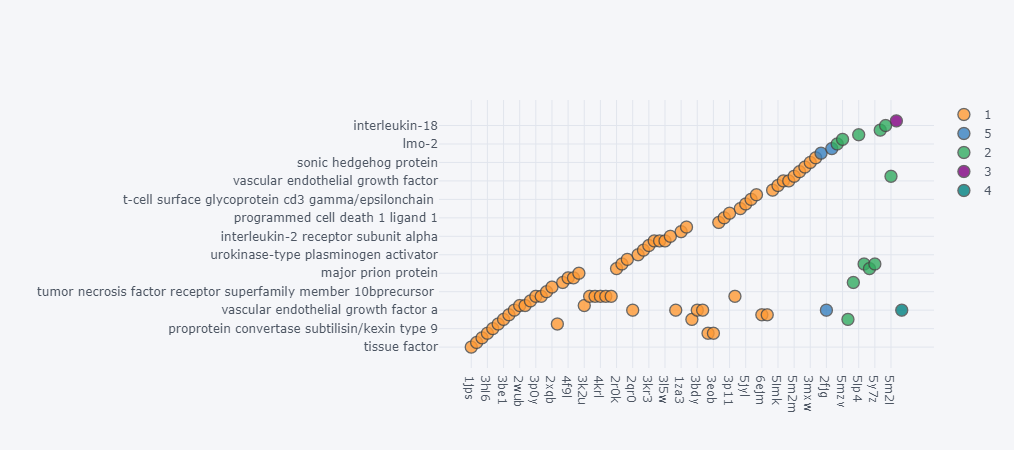

In [33]:
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
cluster_df[cluster_df['delta_g']!= 'None'].iplot(x='pdb_id', y='antigen_name', categories='cluster', mode='markers')